In [1]:
import pandas as pd
import torch
import torch.nn as nn
import networkx as nx
from torch_geometric.utils import from_networkx
from torch_geometric.loader import DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
import numpy as np
import torch.nn.functional as F
from torch_geometric.nn import GINConv, global_mean_pool
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from sklearn.preprocessing import StandardScaler
import hashlib

#### <span style="color:red">Step two:</span> for the IP address, which is being saved in String format, define the function for hashing(encoding) the ip address into integer for future

In [2]:
def hash_ip(ip):
    return int(hashlib.md5(ip.encode()).hexdigest(), 16) % (10 ** 8)

<span style="color:red">Step Three:</span> Start generating the graph, based of what Rudy have created(for DGNN)

However, since GIN is graph-level training not node level, I focused more on graph creation with appropriate informations and labelings

In [4]:
# We first import the dataset into the code, specifically by using a pandas dataframe.
df = pd.read_csv("C:/Users/seoji/Downloads/GraphSAGE-master/DGNN/graph_creation/data/Darknet.CSV")

# Once that's done, we convert the timestamp format to something that can be better used by pandas.
df["Timestamp"] = pd.to_datetime(df["Timestamp"], format="%d/%m/%Y %I:%M:%S %p")
# Then create a rounded to the minute field for grouping later.
df["timestamp_minute"] = df["Timestamp"].dt.floor("min")
# we sort the dataframe by timestamp earliest to latest...
df = df.sort_values(by=["Timestamp"])
# and group the entries by minute...
grouped = df.groupby("timestamp_minute")

# We then create an array for the graphs...
pyg_graphs = []
scaler = StandardScaler()
# Create an array for the features 
all_features = []
# And now, for every minute in the dataset, we run the graph creation code.
for timestamp_minute, group in grouped:
    # For testing, nodes will be named by their index, but you may want to use flow id instead.
    index = 0
    # Then, we create the graph.
    G = nx.DiGraph()
    # Lastly, we establish a previous node variable to store for easier graph creation.
    previous_backward_node = None
     # Now, for each entry...
    for idx, row in group.iterrows():
        # Record the source and destination IP, as well as the flow ID: But also hash it into integer format for
        # Future training
        src_ip = hash_ip(row["Src IP"])
        dst_ip = hash_ip(row["Dst IP"])
        flow_id = row["Flow ID"]

        # Update the dictionary with specific attributes for the forward node
        # Another thing to note is that for pytorch-geo use, you need the features to share the same attributes, so the names are now shared, although the values
        # are being pulled from different places for forwards and backwards nodes.
        forward_features = {
            "total_pkts": row["Total Fwd Packet"],
            "pkts_per_s": row["Fwd Packets/s"],
            "iat_std": row["Fwd IAT Std"],
            "total_len_pkt": row["Total Length of Fwd Packet"],
            "pkt_len_std": row["Fwd Packet Length Std"],
            "seg_size_avg": row["Fwd Segment Size Avg"],
            "init_win_bytes": row["FWD Init Win Bytes"],
            "pkt_len_mean": row["Fwd Packet Length Mean"],
            "iat_max": row["Fwd IAT Max"],
            "avg_pkt_size": row["Average Packet Size"],
            "subflow_bytes": row["Subflow Fwd Bytes"],
            "ip": src_ip,
            # 0 for forward
            "direction": 0,  
        }
        # Add the forward node to the graph
        forward_node_id = f"{index}_fwd"
        G.add_node(forward_node_id, **forward_features)
        all_features.append(list(forward_features.values()))

        # Update the dictionary with specific attributes for the backward node
        backward_features = {
            "total_pkts": row["Total Bwd packets"],
            "pkts_per_s": row["Bwd Packets/s"],
            "iat_std": row["Bwd IAT Std"],
            "total_len_pkt": row["Total Length of Bwd Packet"],
            "pkt_len_std": row["Bwd Packet Length Std"],
            "seg_size_avg": row["Bwd Segment Size Avg"],
            "init_win_bytes": row["Bwd Init Win Bytes"],
            "pkt_len_mean": row["Bwd Packet Length Mean"],
            "iat_max": row["Bwd IAT Max"],
            "avg_pkt_size": row["Average Packet Size"],
            "subflow_bytes": row["Subflow Bwd Bytes"],
            "ip": dst_ip,
            # 1 for backward
            "direction": 1,  
        }
        # Add the backward node to the graph
        backward_node_id = f"{index}_bkd"
        G.add_node(backward_node_id, **backward_features)
        all_features.append(list(backward_features.values()))

        # Connect the edges as appropriate (in this case, chronological order, as we are dealing with network traffic.)
        G.add_edge(forward_node_id, backward_node_id)
        # we then connect the previous backwards node to the next forward node, although we may need to change this in the future.
        if previous_backward_node is not None:
            G.add_edge(previous_backward_node, forward_node_id)

        previous_backward_node = backward_node_id
        index += 1

    # Then start working on the label for the graph: malicious(1) or benign(0) for the testing in the future.
    labels = group["Label"].apply(lambda x: 0 if x.lower() in ["nonvpn", "non-tor"] else 1).tolist()
    graph_label = max(set(labels), key=labels.count)

    # Convert NetworkX graph to PyTorch Geometric Data object
    data = from_networkx(G)
    
    # Extract node features and convert them to tensor
    node_features = []
    for node_id in G.nodes:
        node_features.append(list(G.nodes[node_id].values()))
    
    # Get the data.x as node features and data.y which will be used for detection as a label, which contains information such as 
    # whether this graph is malicious or not
    data.x = torch.tensor(node_features, dtype=torch.float)
    data.y = torch.tensor([graph_label], dtype=torch.long)
    
    #append the data(all of those information) into the pyg_graph 
    pyg_graphs.append(data)

# Normalize the features and ready the graph for the GIN training.
scaler.fit(all_features)
for data in pyg_graphs:
    data.x = torch.tensor(scaler.transform(data.x.numpy()), dtype=torch.float)

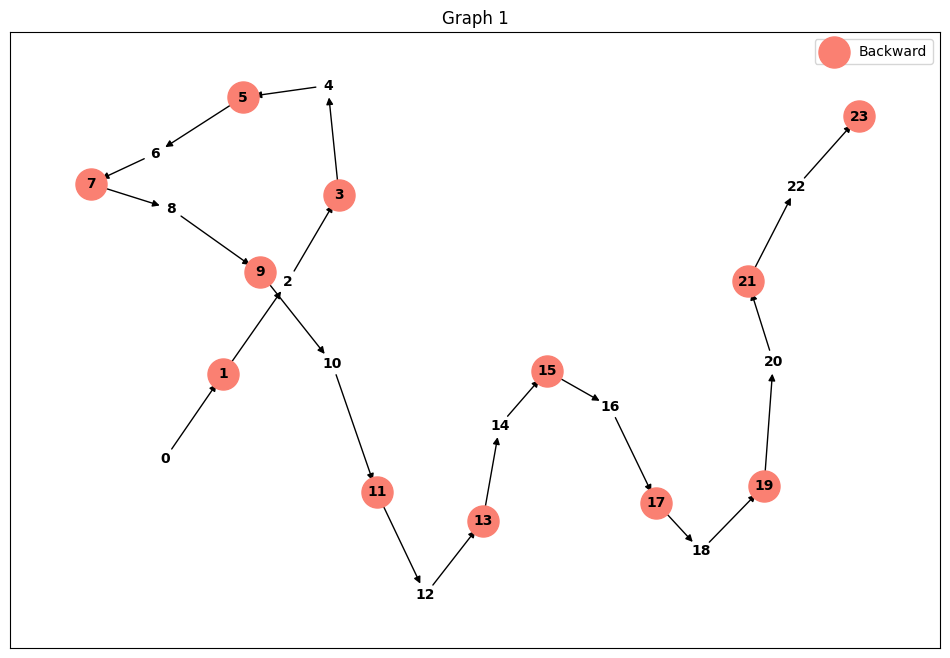

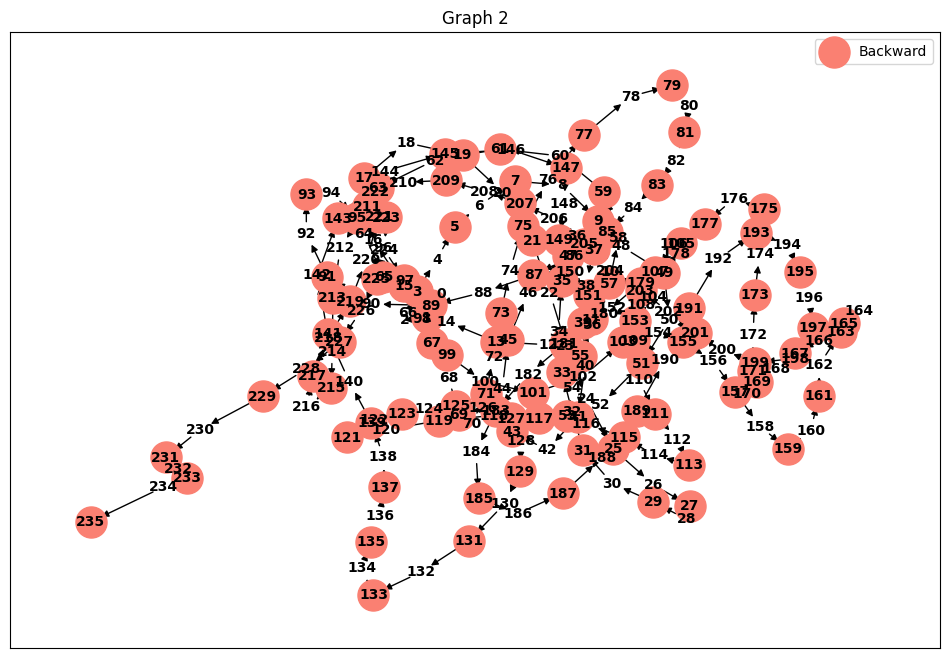

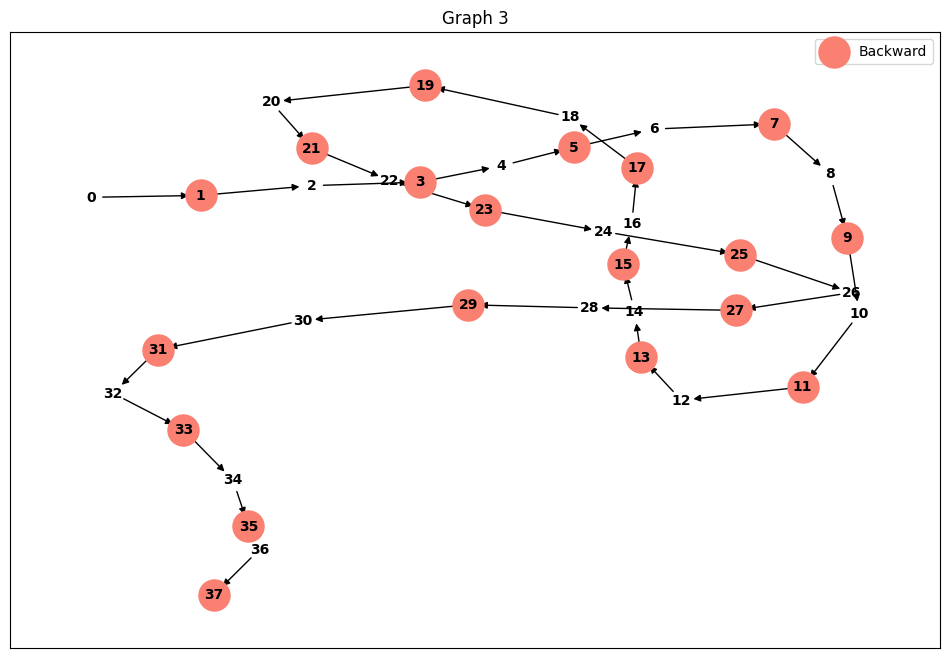

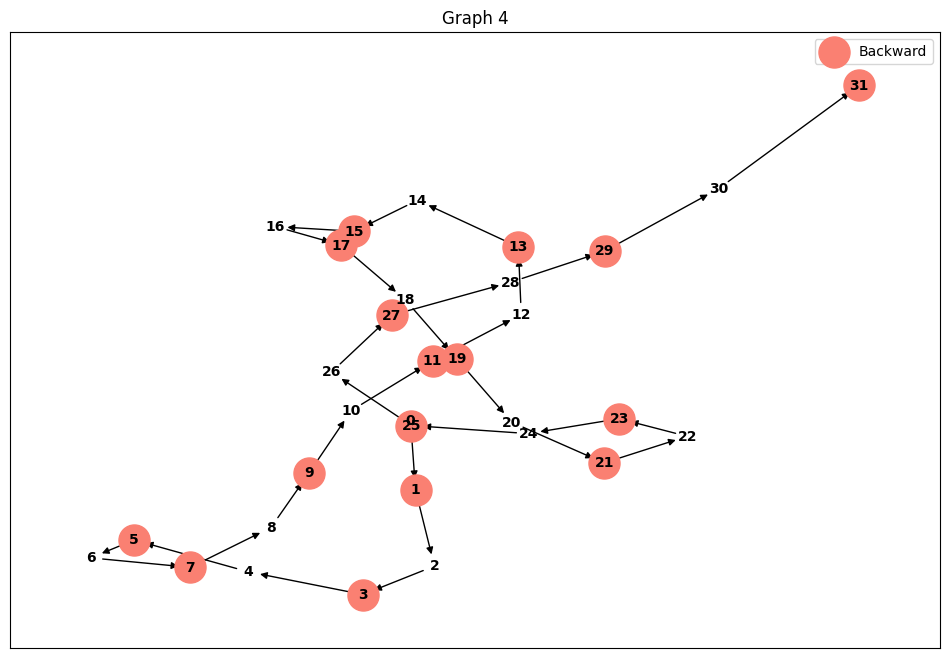

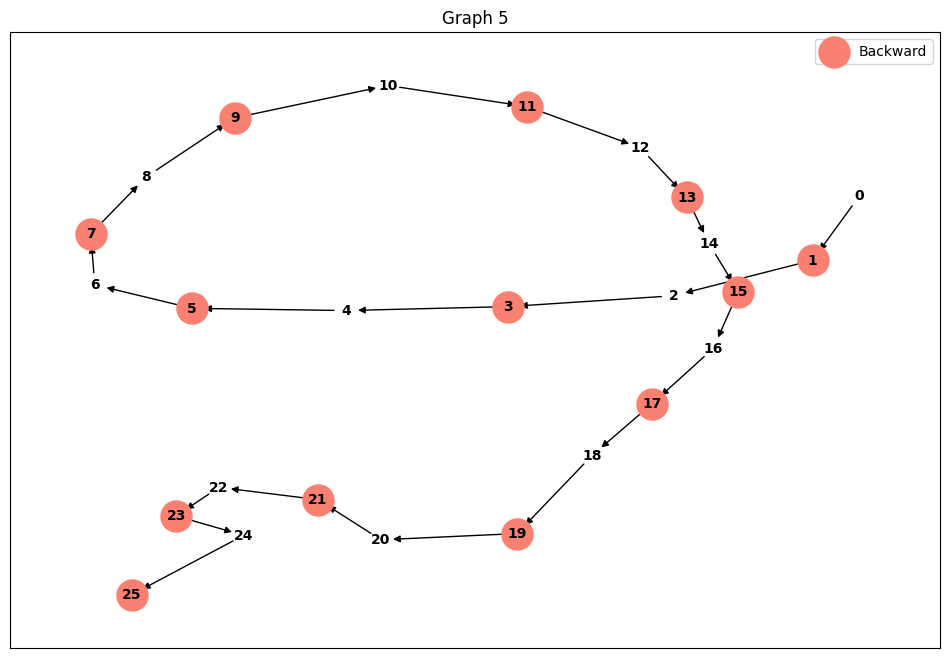

In [5]:
import matplotlib.pyplot as plt

def visualize_graph(G, title):
    pos = nx.spring_layout(G)
    backward_nodes = [node for node in G.nodes if G.nodes[node]['direction'] == 1]

    plt.figure(figsize=(12, 8))
    nx.draw_networkx_nodes(G, pos, nodelist=backward_nodes, node_color='salmon', node_size=500, label='Backward')
    nx.draw_networkx_edges(G, pos)
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
    plt.title(title)
    plt.legend()
    plt.show()

# Visualize a few small graphs
for i, pyg_data in enumerate(pyg_graphs[:5]):  
    G = nx.DiGraph()
    edge_index = pyg_data.edge_index.numpy()
    for j in range(edge_index.shape[1]):
        G.add_edge(edge_index[0, j], edge_index[1, j])

    # Add node attributes back for visualization
    for k in range(pyg_data.x.shape[0]):
        direction = pyg_data.x[k, -1].item() 
        G.nodes[k].update({"features": pyg_data.x[k].numpy(), "direction": direction})

    visualize_graph(G, f"Graph {i+1}")

In [6]:
class GINModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GINModel, self).__init__()
        self.conv1 = GINConv(nn.Sequential(nn.Linear(input_dim, hidden_dim), nn.ReLU(), nn.BatchNorm1d(hidden_dim), nn.Linear(hidden_dim, hidden_dim)))
        self.conv2 = GINConv(nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.ReLU(), nn.BatchNorm1d(hidden_dim), nn.Linear(hidden_dim, hidden_dim)))
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = F.relu(self.conv2(x, edge_index))
        x = self.dropout(x)
        x = global_mean_pool(x, batch)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=-1)

In [7]:
# Adjust this according to what you would like. Currently it splits the data into 10 folds
n_splits = 10 
kf = KFold(n_splits=n_splits, shuffle=True, random_state=False)

# Use cuda if cuda is available or use CPU for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Get the feature dimension of the first graph to determine input_dim
input_dim = pyg_graphs[0].x.shape[1]
hidden_dim = 64
output_dim = 2

# Initialize lists to store losses and F1 scores 
fold_f1_scores = []

# Start splitting the dataset as needed
for fold_idx, (train_index, test_index) in enumerate(kf.split(pyg_graphs)):
    # Print which fold we are working on
    print(f"Processing fold {fold_idx + 1}/{n_splits}")
    
    # Split the train_graphs and test_graphs
    train_graphs = [pyg_graphs[i] for i in train_index]
    test_graphs = [pyg_graphs[i] for i in test_index]

    train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_graphs, batch_size=32, shuffle=False)

    # Create the model
    model = GINModel(input_dim, hidden_dim, output_dim).to(device)
    # This is for the optimizer as the paper has mentioned
    optimizer = Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
    criterion = CrossEntropyLoss()

    # Training
    model.train()
    # Change this range depending on what you want
    for epoch in range(50):
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            out = model(batch.x, batch.edge_index, batch.batch)
            loss = criterion(out, batch.y)
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    y_true_fold = []
    y_pred_fold = []
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            _, predicted = torch.max(out, 1)
            y_true_fold.extend(batch.y.cpu().numpy())
            y_pred_fold.extend(predicted.cpu().numpy())
    
    print(y_pred_fold)
    print(y_true_fold)
    # Calculate F1 score for the current fold
    f1 = f1_score(y_true_fold, y_pred_fold, average='macro')
    fold_f1_scores.append(f1)
    print(f'Fold {fold_idx + 1}, F1 Score: {f1:.4f}')
    

# Calculate the average F1 score across all folds
average_f1_score = np.mean(fold_f1_scores)
print(f'Average F1 Score: {average_f1_score:.4f}')

Processing fold 1/10
[0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,